## Deep Neural Network model: top n feature selection
*Summary:* In this notebook, we use a DNN model to predict attack/normal labels using the top n categorical counts.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

df = pd.concat([train, test]).reset_index(drop=True)
df = df.drop(columns=["id"])
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
257669,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.98057,3721.068786,120.177727,255,3518776216,3453092386,255,0.09944,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [16]:
labels = df['label']
mc_labels = df['attack_cat']
x_df = df.drop(columns=['label', 'attack_cat']).reset_index(drop=True)

### Preprocessing
The preprocessing includes the reduction of categorical features, one hot encoding the selected categorical features, and clamping the features that have a maximum of 10 times the median to the 95th quantile. We start with exploring the value counts of the categorical features.

In [17]:
cat_cols = x_df.select_dtypes(exclude=[np.number]).columns
x_df[cat_cols].describe()

,proto,service,state
count,257673,257673,257673
unique,133,13,11
top,tcp,-,FIN
freq,123041,141321,117164


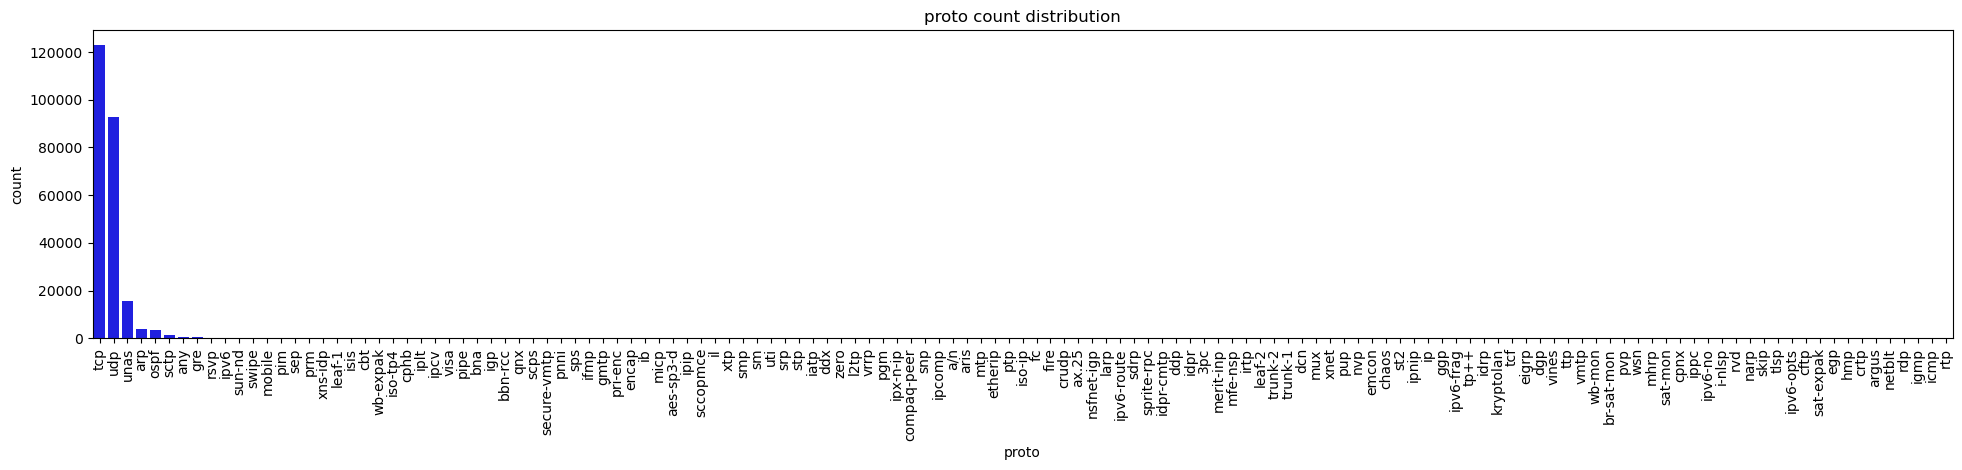

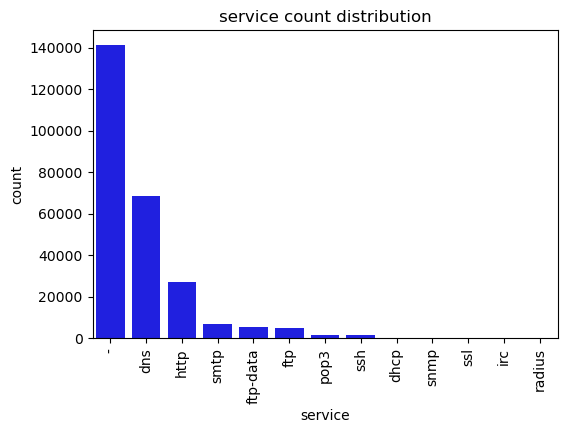

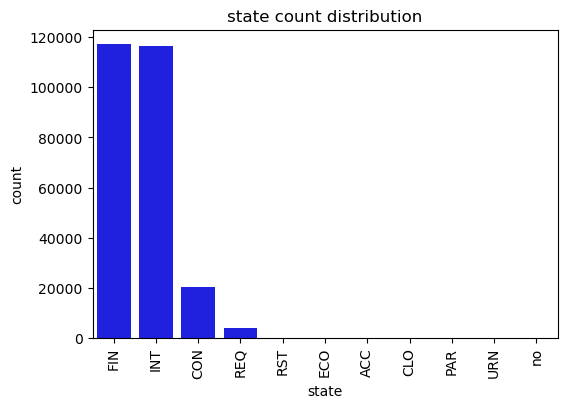

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cat_col(col_name: str, size: tuple):
    fig, ax = plt.subplots(figsize=size)
    ax = sns.countplot(x=col_name, color='blue', data=df, order = df[col_name].value_counts().index)
    ax.set_title(f"{col_name} count distribution")
    plt.xticks(rotation=90)
    plt.show()

plot_cat_col('proto', (24, 4))
plot_cat_col('service', (6, 4))
plot_cat_col('state', (6, 4))

From the above plots, we can see that the categorical distribution is very skewed. The `proto` feature will cause the "curse of dimensionality" as most of the values that this feature can take are very rare. Moreover, the high dimensionality coupled with relatively sparse data describing the dimensions results in a model that is not accurate. In other words, the amount of training data describing the high dimensional features is sparse. 
To counteract this problem, we can reduce the dimensionality by keeping the top `n` counts and grouping the rest together as a single value.
For the categorical variables, we chose the following values for `n` based on the above count plots:
- `proto` keep top 5
- `service` keep top 6
- `state` keep top 4

In [18]:
n_map = {
    'proto': 5,
    'service': 6,
    'state': 4,
}

num_cols = x_df.select_dtypes(include=[np.number]).columns
cat_cols = x_df.select_dtypes(exclude=[np.number]).columns

# reduce categories
for feature in cat_cols:
        top_n = x_df[feature].value_counts().index[:n_map[feature]]
        x_df[feature] = np.where(
            x_df[feature].isin(top_n), 
            x_df[feature], 
            '-')

x_df[cat_cols].describe()

,proto,service,state
count,257673,257673,257673
unique,6,6,5
top,tcp,-,FIN
freq,123041,144721,117164


In [19]:
# Concatenate numerical features and one-hot encoded reduced categorical features
x_df = pd.concat([x_df[num_cols], pd.get_dummies(x_df[cat_cols])], axis=1)

In [20]:
# apply clamping on features that are 10 times the median, so that the features are clamped to the 95th quantile
for feature in x_df.columns:
        if x_df[feature].max() > x_df[feature].median() * 10 and x_df[feature].max() > 10:
            x_df[feature] = np.where(
                x_df[feature] < x_df[feature].quantile(.95),
                x_df[feature], 
                x_df[feature].quantile(.95))

### Binary classification model

Split the dataset into train, test sets with a test set size of 0.2 of total size 

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, labels, stratify=labels, test_size=.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((206138, 56), (51535, 56), (206138,), (51535,))

We standardize the numerical features to satisfy the assumption that many ML models have on the provided data.

In [22]:
from sklearn.preprocessing import StandardScaler

n_num_cols = len(num_cols)
sc = StandardScaler()

X_train.iloc[:, :n_num_cols] = sc.fit_transform(X_train.iloc[:, :n_num_cols])
X_test.iloc[:, :n_num_cols] = sc.transform(X_test.iloc[:, :n_num_cols])

In [23]:
X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

print(f"Training dataset:   {(X_train.shape, y_train.shape)}")
print(f"validation dataset: {(X_val.shape, y_val.shape)}")

Training dataset:   ((196138, 56), (196138,))
validation dataset: ((10000, 56), (10000,))


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [25]:
def create_binary_model():
    model = keras.Sequential(
        [
            layers.Dense(43, activation='relu', input_dim=X_train.shape[1]),
            layers.BatchNormalization(),
            layers.Dropout(rate=0.028454008433744526),
            layers.Dense(25, activation='relu', use_bias=True),
            layers.Dense(90, activation='relu', use_bias=True),
            layers.Dense(1, activation='sigmoid', use_bias=True)
        ]
    )
    model.compile('adam', loss='binary_crossentropy', metrics='accuracy')
    return model

model = create_binary_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1140      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
_________________________________________________________________


In [26]:
import os

checkpoint_path = "../models/model_dnn_b_topn.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

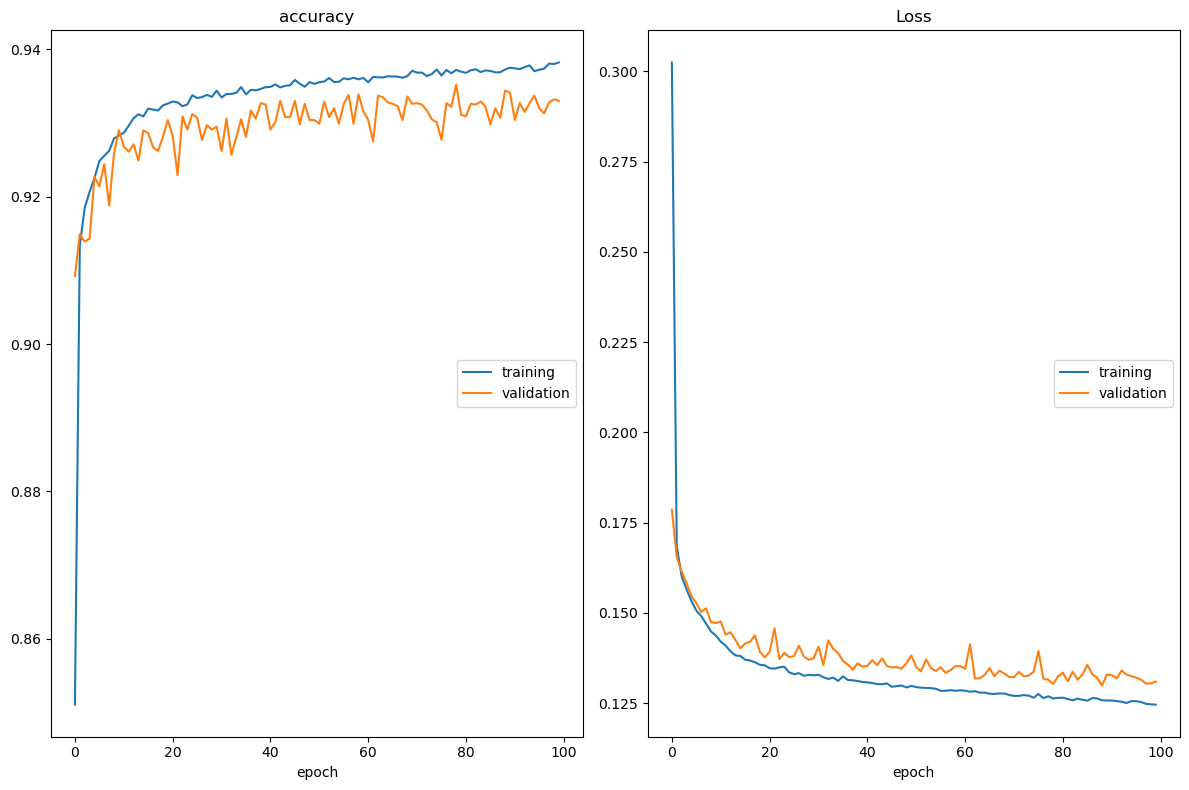

accuracy
	training         	 (min:    0.851, max:    0.938, cur:    0.938)
	validation       	 (min:    0.909, max:    0.935, cur:    0.933)
Loss
	training         	 (min:    0.125, max:    0.302, cur:    0.125)
	validation       	 (min:    0.130, max:    0.179, cur:    0.131)
197/197 - 1s - loss: 0.1246 - accuracy: 0.9382 - val_loss: 0.1310 - val_accuracy: 0.9330 - 841ms/epoch - 4ms/step


In [27]:
EPOCHS = 407
BATCH_SIZE = 540

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=BATCH_SIZE)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras(), cp_callback])

In [28]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape((y_pred.shape[0],))

1611/1611 [==============================] - 1s 841us/step


In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred.round())
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(list(labels.unique())))

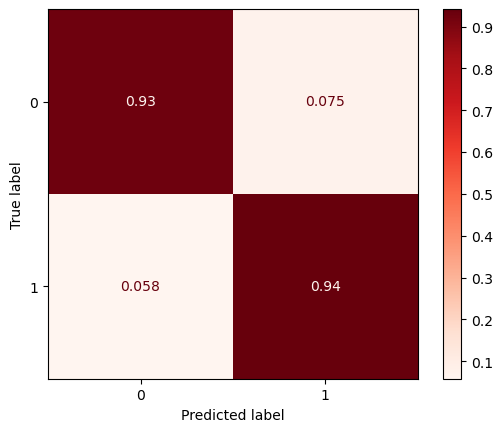

In [30]:
import matplotlib.pyplot as plt

disp.plot(cmap=plt.cm.Reds)

In [31]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, f1_score

ys = y_test
ys_pred = y_pred.round()

print(f"Accuracy score:                   {accuracy_score(ys, ys_pred)}")
print(f"Matthews correlation coefficient: {matthews_corrcoef(ys, ys_pred)}")
print(f"recall score (weighted):          {recall_score(ys, ys_pred)}")
print(f"precision score (weighted):       {precision_score(ys, ys_pred)}")
print(f"f1 score (weighted):              {f1_score(ys, ys_pred)}")


Accuracy score:                   0.9360046570292034
Matthews correlation coefficient: 0.8624779136396286
recall score (weighted):          0.9423615337796714
precision score (weighted):       0.9566265060240964
f1 score (weighted):              0.9494404415146405


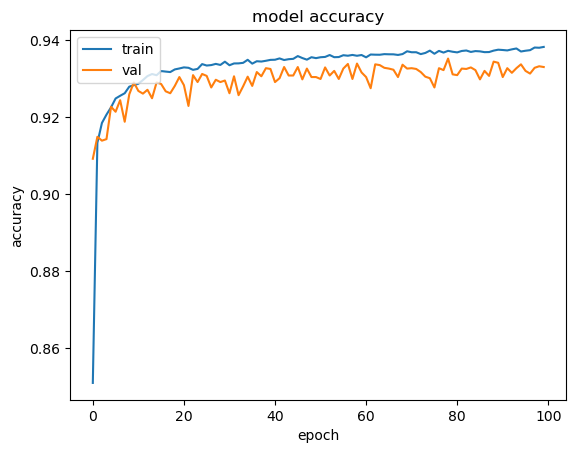

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

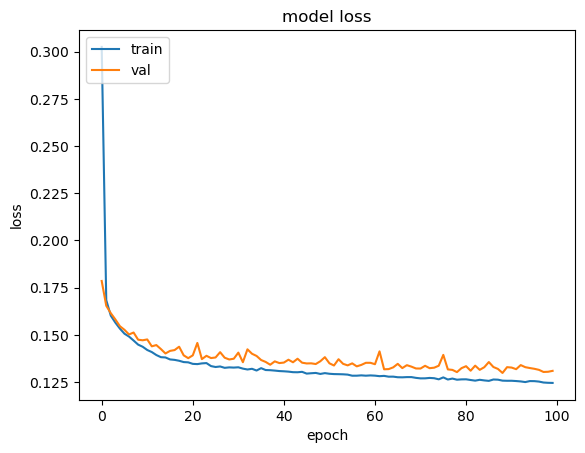

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Multi-class model

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, pd.get_dummies(mc_labels), stratify=pd.get_dummies(mc_labels), test_size=.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((206138, 56), (51535, 56), (206138, 10), (51535, 10))

In [35]:
from sklearn.preprocessing import StandardScaler

n_num_cols = len(num_cols)
sc = StandardScaler()

X_train.iloc[:, :n_num_cols] = sc.fit_transform(X_train.iloc[:, :n_num_cols])
X_test.iloc[:, :n_num_cols] = sc.transform(X_test.iloc[:, :n_num_cols])

In [36]:
X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

print(f"Training dataset:   {(X_train.shape, y_train.shape)}")
print(f"validation dataset: {(X_val.shape, y_val.shape)}")

Training dataset:   ((196138, 56), (196138, 10))
validation dataset: ((10000, 56), (10000, 10))


In [37]:
def create_multiclass_model():
    model = keras.Sequential(
        [
            layers.Dense(27, activation='relu', input_dim=X_train.shape[1]),
            layers.BatchNormalization(),
            layers.Dense(173, activation='relu', use_bias=True),
            layers.Dropout(rate=0.2942475563821516),
            layers.Dense(151, activation='relu', use_bias=True),
            layers.Dense(21, activation='relu', use_bias=True),
            layers.Dense(10, activation='softmax', use_bias=True)
        ]
    )
    model.compile('adam', loss='categorical_crossentropy', metrics='accuracy')
    return model

model = create_multiclass_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               5700      
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 37,010
Trainable params: 37,010
Non-trainable params: 0
_________________________________________________________________


In [38]:
import os

checkpoint_path = "../models/model_dnn_mc_topn.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

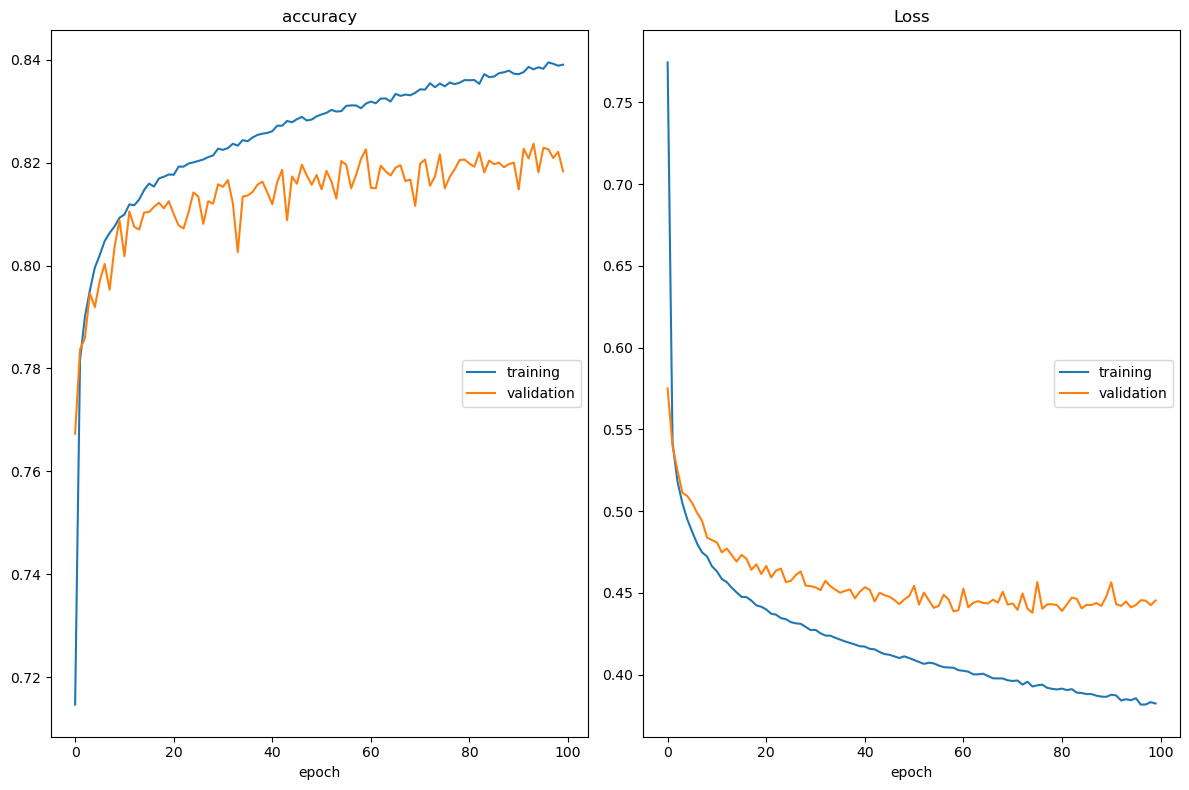

accuracy
	training         	 (min:    0.715, max:    0.839, cur:    0.839)
	validation       	 (min:    0.767, max:    0.824, cur:    0.818)
Loss
	training         	 (min:    0.382, max:    0.774, cur:    0.382)
	validation       	 (min:    0.438, max:    0.575, cur:    0.445)
197/197 - 1s - loss: 0.3824 - accuracy: 0.8390 - val_loss: 0.4455 - val_accuracy: 0.8183 - 1s/epoch - 5ms/step


In [39]:
EPOCHS = 137
BATCH_SIZE = 296

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=BATCH_SIZE)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras(), cp_callback])

In [40]:
y_pred = model.predict(X_test)

1611/1611 [==============================] - 2s 1ms/step


In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred.argmax(axis=1))
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(list(mc_labels.unique())))

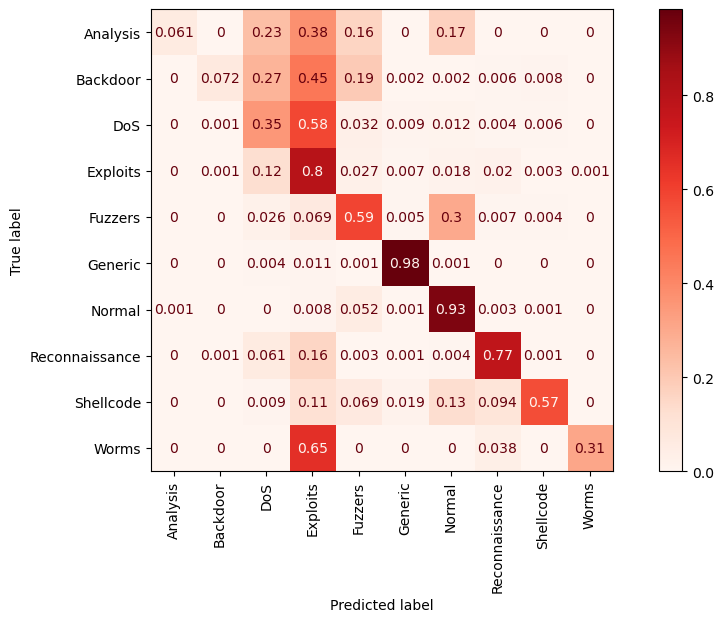

In [42]:
plt.rcParams["figure.figsize"] = (12,6)
disp.plot(cmap=plt.cm.Reds, xticks_rotation=90)

In [43]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, f1_score, auc

ys = y_test.to_numpy().argmax(axis=1)
ys_pred = y_pred.argmax(axis=1)

print(f"Accuracy score:                   {accuracy_score(ys, ys_pred)}")
print(f"Matthews correlation coefficient: {matthews_corrcoef(ys, ys_pred)}")
print(f"recall score (weighted):          {recall_score(ys, ys_pred, average='weighted')}")
print(f"precision score (weighted):       {precision_score(ys, ys_pred, average='weighted')}")
print(f"f1 score (weighted):              {f1_score(ys, ys_pred, average='weighted')}")

Accuracy score:                   0.8250121276802174
Matthews correlation coefficient: 0.7715432713163802
recall score (weighted):          0.8250121276802174
precision score (weighted):       0.8214094219773
f1 score (weighted):              0.8169666405526563
